In [1]:
import tweepy
from tweepy import OAuthHandler

from dotenv import load_dotenv

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
import re
import os
import datetime

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
import emoji

# TextBlob
from textblob import TextBlob

# scikit-learn
from sklearn.feature_extraction.text import CountVectorizer

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [200]:
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

#sns.color_palette("rocket_r", as_cmap=True)
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
#plt.rcParams.update({'font.size': 22})

# random seed
np.random.seed(42)

# load .env
load_dotenv() 

# ignore warnings
import warnings
#warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /home/m9/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/m9/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/m9/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/m9/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Set Twitter credential

In [201]:
api_key = os.environ["API_KEY"]
api_key_secret = os.environ["API_KEY_SECRET"]
access_token = os.environ["ACCESS_TOKEN"]
access_token_secret = os.environ["ACCESS_TOKEN_SECRET"]

# Use the above credentials to authenticate the API.
auth = tweepy.OAuthHandler( api_key , api_key_secret )
auth.set_access_token( access_token , access_token_secret )
api = tweepy.API(auth)

In [202]:
TOPIC = ["chelsea"]
NUMBER_OF_TWEETS = 1000

In [203]:
def get_tweets(Topic, Count, save=True):   
    columns = ["Date", "User", "IsVerified", "Tweet", "Likes", "RT", 'User_location']
    df = pd.DataFrame(columns=columns)
    
    cursor = tweepy.Cursor(
        api.search_tweets, 
        q = Topic, 
        count = 100, 
        lang = "en",
        exclude = 'retweets'
    ).items()
    
    for index, tweet in zip(range(Count), cursor):
        print(index, end='\r')
        df.loc[index,"Date"] = tweet.created_at
        df.loc[index,"User"] = tweet.user.name
        df.loc[index,"IsVerified"] = tweet.user.verified
        df.loc[index,"Tweet"] = tweet.text
        df.loc[index,"Likes"] = tweet.favorite_count
        df.loc[index,"RT"] = tweet.retweet_count
        df.loc[index,"User_location"] = tweet.user.location
    
    if save:
        df.to_csv("TweetDataset.csv", index=False)
        
    return df

# Call the function to extract the data. pass the topic and filename you want the data to be stored in.
df = get_tweets(TOPIC , Count=NUMBER_OF_TWEETS)
df

Unexpected parameter: exclude
Unexpected parameter: exclude


Unexpected parameter: exclude


Unexpected parameter: exclude


Unexpected parameter: exclude


Unexpected parameter: exclude


Unexpected parameter: exclude


Unexpected parameter: exclude


Unexpected parameter: exclude


Unexpected parameter: exclude


,Date,User,IsVerified,Tweet,Likes,RT,User_location
0,2022-10-21 21:41:44+00:00,James,False,@ManUtd Chelsea V Manchester United tickets av...,0,0,
1,2022-10-21 21:41:41+00:00,Everton Women TV Podcast,False,"Pete and Julie reviewing the Chelsea game, pre...",0,0,
2,2022-10-21 21:41:37+00:00,Chelsea Door | chelseafc,False,Ready Go.\n#chelsea | #Con | #foot https://t.c...,0,0,
3,2022-10-21 21:41:37+00:00,AntLar,False,@Mattsson123 N.Forest 0-3 Liverpool\nEverton 0...,0,0,"Göteborg, Sverige"
4,2022-10-21 21:41:35+00:00,Jules vanier,False,@Cristiano good day!\nPlease join Chelsea to s...,0,0,
...,...,...,...,...,...,...,...
995,2022-10-21 20:50:20+00:00,Femi,False,Ronaldo stans waiting for us to lose to Chelsea 💀,2,0,"Folagoro,Lagos State"
996,2022-10-21 20:50:09+00:00,MR SKICHE,False,@Martins_Afeni @DoyathingBig @piersmorgan @top...,0,0,
997,2022-10-21 20:50:09+00:00,Toon Man,False,I am flying across the pond for @nufc matches ...,0,0,"Columbia, SC"
998,2022-10-21 20:50:07+00:00,revolvermag,True,"💣 Babymetal, Architects, Chelsea Grin, Foreign...",11,5,"New York, NY"


In [204]:
def word_cloud(df, column_name="Tweet"):
    #create instance of the WordCloud() 
    word_cloud = WordCloud(height=1080, width=2048, background_color='white')

    #get the text in a big string
    txt = df[column_name].str.lower()
    text=" ".join([str(word) for word in txt])

    #generate the word cloud
    word_cloud.generate(text)

    #display now
    plt.figure(figsize=(14, 12));
    plt.imshow(word_cloud);
    plt.axis("off");
    plt.title(f"Most {column_name} Common Words");

In [205]:
def get_top_tweet_bigrams(df, column_name="Tweet", ngram=2, n=None):
    # select all text for selected dialect
    txt = df[column_name].str.lower()
    # create a matrix of token counts
    vec = CountVectorizer(ngram_range=(ngram, ngram)).fit(txt)
    # bag of words  
    bag_of_words = vec.transform(txt)
    # sum bag of words 
    sum_words = bag_of_words.sum(axis=0) 
    # frequency of each word in selected texts
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    # top n words repeates in selected texts 
    top = words_freq[:n]
    #print(top)
    x, y = map( list, zip(*top) )
    nn = np.arange(len(x))
    
    plt.figure(figsize=(10,8))
    plt.barh(x, y, align='center', alpha=0.2)
    plt.plot(y, nn, '-o', markersize=5, alpha=0.8)
    plt.yticks(nn, x);
    plt.xlabel('Word Number');
    plt.title(f'Top {n} words in  tweets')

## Clean Text

Next step to try several methods one at a time to clean our tweets like:-

    * Select only from text
    * Remove username "@handle" from text
    * Remove URL from text
    * Remove punctuation, emoji and smileys from text
    * Remove \n, \t ,,, etc from text
    * Remove Diacritization from text
    * Remove Arabic Stop Words from text


In [206]:
sample_tweet = df.Tweet[0]

### Remove username "@handle"

In [207]:
def remove_handle(text):
    handle_pattern = '@[^\s]+'
    return re.sub(handle_pattern, '', text) # return text without @handle

remove_handle("@user we are happy!")

' we are happy!'

### Remove URL

In [208]:
def remove_url(text):
    url_pattern = re.compile(r'https?://\S+')
    return url_pattern.sub(r'', text)

remove_url("https://t.co/8i1C8Mucr1' Arsenal Trophy Cabinet 'https://t.co/EeWtTjOeTF")

" Arsenal Trophy Cabinet '"

### Remove RT

In [209]:
def remove_rt(text):
    # ([RT]) : Remove "RT" from the tweet
    url_pattern = re.compile(r'([RT])')
    return url_pattern.sub(r'', text)
                             
remove_rt("RT sdsd")

' sdsd'

### Remove HTML

In [210]:
def remove_html(text):
    html_pattern = re.compile(r'<.*?>')
    return html_pattern.sub(r'', text)

example = """<div>
<h1>head</h1>
<p>paragraph</p>
<a href="https://www.kaggle.com/">url</a>
</div>"""

remove_html(example)

'\nhead\nparagraph\nurl\n'

### Replace emoji and smileys by their corresponding text

Here we scrap emoticons and their corresponding text using BeautifulSoup from emoticonr

In [211]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

url = "https://www.emoticonr.com/emoticons"  # change to whatever your url is

page = urlopen(url).read()
soup = BeautifulSoup(page)

smileys = {}
for div in soup.find_all("div", {"class": "tableText"}):
    divs = div.find_all("div")
    smileys[divs[1].text] = divs[0].text
    
#
smileys_df = pd.DataFrame(
    smileys.items(), 
    columns = ['smiley', 'meaning'],
    index=np.arange(len(smileys))
)
smileys_df

,smiley,meaning
0,>-),Alien
1,O:),Angel
2,O:-),Angel
3,X(,Angry or Grumpy
4,>:-(,Angry or Grumpy
...,...,...
149,;-),Winking
150,:-S,Worried
151,(:|,Yawn
152,>:O,Yelling


In [212]:
def replace_emoji(text):
    #replace emojis by their corresponding text
    text = emoji.demojize(text, delimiters=("", ""))
    #replace smileys by their corresponding text
    new_text = ""
    for w in text.split():
        if w.upper() in smileys:
            new_text = new_text + smileys_df.meaning[smileys_df.smiley==w.upper()].values[0] + " "
        else:
            new_text = new_text + w + " "
    return new_text

text = "game is on 🔥 :-) 😀 :|  "

print(text) # with emoji
print(replace_emoji(text))

game is on 🔥 :-) 😀 :|  
game is on fire  Smile or happy face grinning_face  Straight face 


### Remove punctuation

In [213]:
def remove_punc(text):
    # remove '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    return re.sub(r'[^\w\s]', '', text)

text = "Gfg, is best : for ! Geeks ;"
remove_punc(text)

'Gfg is best  for  Geeks '

### Remove whitespace from text

In [214]:
# remove whitespace from text
def remove_whitespace(text):
    return  " ".join(text.split())

remove_whitespace("   abc abc ab c  ")

'abc abc ab c'

### Remove Non-ASCI

In [215]:
def remove_non_ascii(text):
    """
        Remove non-ASCII characters 
    """
    return re.sub(r'[^\x00-\x7f]',r'', text)
    #return ''.join([x for x in text if x in string.printable]) 

remove_non_ascii('Ǹ text Ǹ')

' text '

### Chatwords conversion

Here we scrap chatwords and their meanings using BeautifulSoup from englishclub

In [216]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

url = "https://www.englishclub.com/esl-chat/abbreviations.htm"  # change to whatever your url is

page = urlopen(url).read()
soup = BeautifulSoup(page)
len(soup.find_all('table'))

chatwords = {}
soup.find_all('table')[1]
for table in soup.find_all('table'):
    for tr in table.find_all('tr'):
        tds = tr.find_all('td')
        chatwords[tds[0].text.upper()] = tds[1].text
        
chatwords_df = pd.DataFrame(
    chatwords.items(), 
    columns = ['abbreviation', 'meaning'],
    index=np.arange(len(chatwords))
)

chatwords_df

,abbreviation,meaning
0,?4U,I have a question for you.
1,^^,Read line above
2,<3,love
3,2,to
4,2MRW,tomorrow
...,...,...
71,W/,with
72,W/O,without
73,WRU,Where are you?
74,XO,hugs and kisses / love


In [217]:
# Chatwords conversion
def convert_chat_words(text):
    new_text = ""
    for w in text.split():
        if w.upper() in chatwords:
            new_text = new_text + chatwords_df.meaning[chatwords_df.abbreviation==w.upper()].values[0] + " "
        else:
            new_text = new_text + w + " "
    return new_text

convert_chat_words("one minute BRB")

'one minute Be right back '

### Correct Spellings

In [218]:
def correct_sentence_spelling(sentence):
    sentence = TextBlob(sentence)
    result = sentence.correct()
    return str(result)

correct_sentence_spelling('Correct me Plaese!')

'Correct me Please!'

### word tokenizer

    remove non alpha
    remove stopwords (such as “the”, “a”, “an”, “in”)

In [219]:
def word_tokenizer(text):
    """
    word tokenize
    remove non alpha 
    remove stopwords (such as “the”, “a”, “an”, “in”)
    """
    words = [word for word in word_tokenize(text) if((word not in stop_words)&(word.isalpha())&(len(word)>1))]
    #words = [word for word in word_tokenize(text) if((word.isalpha())&(len(word)>1))]
    return ' '.join(words)

word_tokenizer(sample_tweet)

'ManUtd Chelsea Manchester United tickets available sale You DM'

### Lemmatisation and Stemming

In [220]:
def do_stemming(text):
    #Create instance of a PorterStemmer
    #stemmer = PorterStemmer()
    stemmer = SnowballStemmer(language='english')
    new_str = ""
    for word in text.split():
        tokenizer = word_tokenizer(word)
        new_str = new_str + stemmer.stem(tokenizer) + " "
    return new_str

print(sample_tweet)
print(do_stemming(sample_tweet))

@ManUtd Chelsea V Manchester United tickets available for sale 
You can DM
manutd chelsea  manchest unit ticket avail  sale you  dm 


In [221]:
def do_lemmatizing(text):
    #Create instance of a PorterStemmer
    lemmatizer = WordNetLemmatizer()
    new_str = ""
    for word in text.split():
        tokenizer = word_tokenizer(word)
        new_str = new_str + lemmatizer.lemmatize(tokenizer) + " "
    return new_str

print(sample_tweet)
print(do_lemmatizing(sample_tweet))

@ManUtd Chelsea V Manchester United tickets available for sale 
You can DM
ManUtd Chelsea  Manchester United ticket available  sale You  DM 


In [222]:
def clean_text(tweet, normalize=None):
    tweet = tweet.lower()
    tweet = word_tokenizer(tweet)
    tweet = remove_handle(tweet)
    tweet = remove_rt(tweet)
    tweet = remove_url(tweet)
    tweet = remove_html(tweet)
    #tweet = remove_non_ascii(tweet)
    #tweet = correct_sentence_spelling(tweet)
    tweet = replace_emoji(tweet)
    tweet = remove_punc(tweet)
    tweet = convert_chat_words(tweet)
    tweet = remove_whitespace(tweet)
    
    if normalize == 'lemmatize':
        tweet = do_lemmatizing(tweet)
    elif normalize == 'stem':
        tweet = do_stemming(tweet)
    else:
        pass
    
    # if empty tweet
    if not tweet:
        tweet = ' '
        
    return tweet
  
print(sample_tweet)
clean_text(sample_tweet)

@ManUtd Chelsea V Manchester United tickets available for sale 
You can DM


'manutd chelsea manchester united tickets available sale Direct Message'

In [223]:
df["clean_tweet"] = df.Tweet.apply(lambda tweet: clean_text(tweet))

In [224]:
df.clean_tweet.isnull().sum()

0

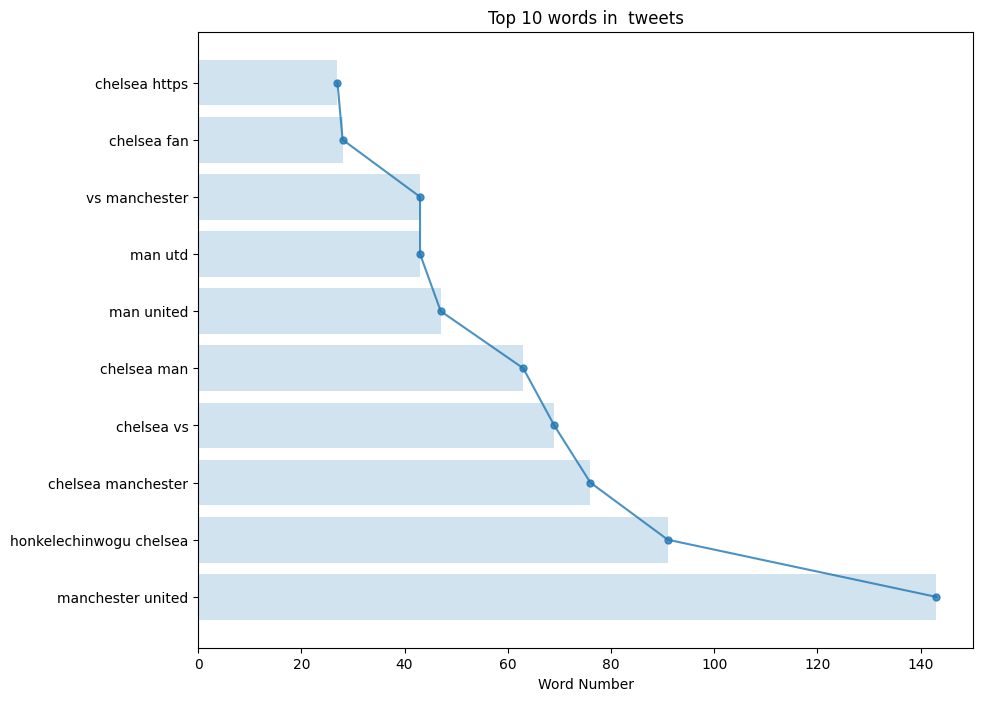

In [225]:
get_top_tweet_bigrams(df, column_name="clean_tweet", ngram=2, n=10)

# Save tweets

In [226]:
df.to_csv("Processed_Tweets_Dataset.csv", index=False)
print('Done!')

Done!


In [227]:
df.shape

(1000, 8)